# 데이터마이닝


# k-NN & Naive Bayes

## k-NN 분류기(범주형 결과)
* 모델 중심이 아닌 데이터 중심
* 데이터에 대한 가정을 하지 않음
* 간단한 아이디어: 레코드를 유사한 레코드로 분류
* 분류하고자 하는 새로운 레코드의 유사한 k개의 이웃 레코드를 식별
* 이웃 레코드를 사용해 새로운 레코드를 특정 클래스로 분류. 예측 변수 값 X1, X2, ... Xp가 유사한 레코드를 의미
* 이웃 레코드들이 속한 클래스들을 참조하여 분류하고자 하는 레코드에 클래스 할당

## 이웃 결정하기
* 가장 보편적으로 사용되는 거리 측도는 유클리드 거리


## 분류 규칙
* 가장 단순한 경우는 k = 1
* k > 1의 이웃을 갖는 경우
* ** 분류될 레코드와 가장 가까운 k 개의 이웃을 찾는다
* ** 레코드를 분류하기 위해 다수결 결정 규칙을 사용한다. 즉, 레코드는 k개 이웃들의 다수가 속하는 클래스로
분류된다.

In [64]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import matplotlib.pylab as plt
import koreanize_matplotlib
import numpy as np

In [4]:
mower_df = pd.read_csv('https://raw.githubusercontent.com/reisanar/datasets/master/RidingMowers.csv')
mower_df['Number'] = mower_df.index + 1
mower_df.head()

,Income,Lot_Size,Ownership,Number
0,60.0,18.4,Owner,1
1,85.5,16.8,Owner,2
2,64.8,21.6,Owner,3
3,61.5,20.8,Owner,4
4,87.0,23.6,Owner,5


In [5]:
trainData, validData = train_test_split(mower_df, test_size = 0.4, random_state= 26)
print(trainData.shape, validData.shape)
newHousehold = pd.DataFrame([{'Income':60, 'Lot_Size':20}])
newHousehold

(14, 4) (10, 4)


,Income,Lot_Size
0,60,20


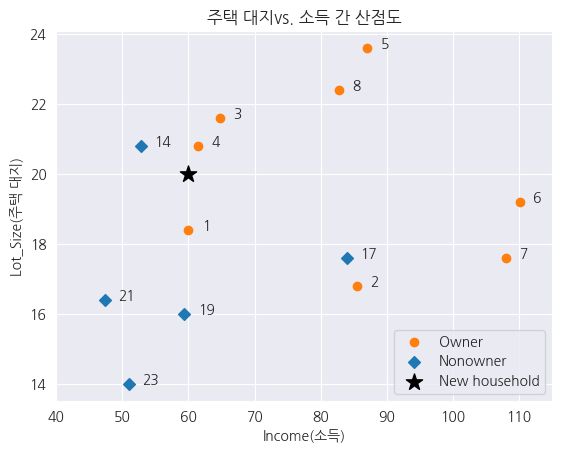

In [8]:
# Scatter Plot
fig, ax = plt.subplots()

subset = trainData.loc[trainData['Ownership']=='Owner']
ax.scatter(subset.Income, subset.Lot_Size, marker = 'o', label = 'Owner', color = 'C1')

subset = trainData.loc[trainData['Ownership']=='Nonowner']
ax.scatter(subset.Income, subset.Lot_Size, marker = 'D', label = 'Nonowner', color = 'C0')

ax.scatter(newHousehold.Income, newHousehold.Lot_Size, marker = '*', label = 'New household', color = 'black', s = 150)

plt.title('주택 대지vs. 소득 간 산점도')
plt.xlabel('Income(소득)')
plt.ylabel('Lot_Size(주택 대지)')
for _, row in trainData.iterrows():
    ax.annotate(row.Number, (row.Income + 2, row.Lot_Size))

handles, labels = ax.get_legend_handles_labels()
ax.set_xlim(40, 115)
ax.legend(handles, labels, loc = 4)

plt.show()

In [13]:
# 정규화된 학습, 검증 및 전체 데이터 프레임 초기화, 훈련 데이터를 사용하여 변환을 학습
scaler = preprocessing.StandardScaler()
scaler.fit(trainData[['Income', 'Lot_Size']])

# 전체 데이터 반환
mowerNorm = pd.concat([pd.DataFrame(scaler.transform(mower_df[['Income', 'Lot_Size']]),
                                    columns = ['zIncome', 'zLot_Size']),
                       mower_df[['Ownership', 'Number']]], axis = 1)
trainNorm = mowerNorm.iloc[trainData.index]
validNorm = mowerNorm.iloc[validData.index]
newHouseholdNorm = pd.DataFrame(scaler.transform(newHousehold), columns = ['zIncome', 'zLot_Size'])

# Use k-nearest neighbor
knn = NearestNeighbors(n_neighbors=3)
knn.fit(trainNorm[['zIncome', 'zLot_Size']])
distances, indices = knn.kneighbors(newHouseholdNorm)
print(trainNorm.iloc[indices[0],:])    # indices is a list of lists, we are only intereseted in the first element

     zIncome  zLot_Size Ownership  Number
3  -0.409776   0.743358     Owner       4
13 -0.804953   0.743358  Nonowner      14
0  -0.477910  -0.174908     Owner       1


## 값 선택
* K가 너무 작으면 데이터의 노이즈를 적합할 위험
* k가 너무 크면 이 알고리즘의 주된 장점 중 하나인 데이터의 지역적 구조를 파악할 수 있는 능력을 놓칠 수 있음
* 학습 데이터셋을 사용해 검증 데이터셋의 레코드를 분류한 다음 다양한 값에 대해 오차율을 계산하여 선택 가장 븐루 성능이 좋은 k 선택
* k 가 선택되면 새로운 레코드를 분류하기 위해 학습 데이터셋과 테스트 데이터셋을 훔치고 알고리즘 반복

In [18]:
# 다양한 k에 대한 k-NN의 검증 정확도
train_X = trainNorm[['zIncome', 'zLot_Size']]
train_y = trainNorm['Ownership']
valid_X = validNorm[['zIncome', 'zLot_Size']]
valid_y = validNorm['Ownership']

# Train a classifier for different values of k
results = []
for k in range(1,15):
    knn = KNeighborsClassifier(n_neighbors = k).fit(train_X, train_y)
    results.append({
        'k': k,
        'accuracy':accuracy_score(valid_y, knn.predict(valid_X))
    })

# Convert results to a pandas data frame
results = pd.DataFrame(results)
print(results)

     k  accuracy
0    1       0.6
1    2       0.7
2    3       0.8
3    4       0.9
4    5       0.7
5    6       0.9
6    7       0.9
7    8       0.9
8    9       0.9
9   10       0.8
10  11       0.8
11  12       0.9
12  13       0.4
13  14       0.4


### k=4에 대한 분류
* K가 선택되면 새로운 레코드를 분류하기 위해 학습/테스트 데이터셋을 합치고 알고리즘 반복

In [19]:
# 전체 데이터 셋에 대한 재훈련
mower_X = mowerNorm[['zIncome', 'zLot_Size']]
mower_y = mowerNorm['Ownership']
knn = KNeighborsClassifier(n_neighbors = 4).fit(mower_X, mower_y)
distances, indices = knn.kneighbors(newHouseholdNorm)
print(knn.predict(newHouseholdNorm))
print('Distances', distances)
print('Indices', indices)
print(mowerNorm.iloc[indices[0],:])

['Owner']
Distances [[0.31358009 0.40880312 0.44793643 0.61217726]]
Indices [[ 3  8 13  0]]
     zIncome  zLot_Size Ownership  Number
3  -0.409776   0.743358     Owner       4
8  -0.069107   0.437269     Owner       9
13 -0.804953   0.743358  Nonowner      14
0  -0.477910  -0.174908     Owner       1


## 레코드 분류의 기본 : 다수결의 원칙
* 근접 이웃들 중 다수가 속한 클래스의 member가 되도록 새로운 레코드 분류
* 즉, 다수 == 클래스 멤버십 확률(레코드가 클래스에 속할 확률에 대한 컷오프 값)
* 소득($60,000) & 주택 크기(20,000m^2)에 대한 근접 이웃
* Owner = 3, Non-owner = 1 -> 0.75
* 코드에서는 'Owner'로 할당

In [20]:
# 전체 데이터셋에 대한 재훈련
mower_X = mowerNorm[['zIncome', 'zLot_Size']]
mower_y = mowerNorm['Ownership']
knn = KNeighborsClassifier(n_neighbors = 4).fit(mower_X, mower_y)
distances, indices = knn.kneighbors(newHouseholdNorm)
print(knn.predict(newHouseholdNorm))
print('Distances', distances)
print('Indices', indices)
print(mowerNorm.iloc[indices[0],:])

['Owner']
Distances [[0.31358009 0.40880312 0.44793643 0.61217726]]
Indices [[ 3  8 13  0]]
     zIncome  zLot_Size Ownership  Number
3  -0.409776   0.743358     Owner       4
8  -0.069107   0.437269     Owner       9
13 -0.804953   0.743358  Nonowner      14
0  -0.477910  -0.174908     Owner       1


## k-NN 알고리즘의 장단점
### 장점
* 단순하다는 것과 모수에 대한 가정이 거의 없다
* 학습 데이터셋이 충분히 많을 때, 특히 각 클래스의 특성이 예측 변수 값들의 여러 조합으로 결정될 때 탁월한 성능

### 단점
* 학습 데이터셋으로부터 모수를 추정하는 데 걸리는 시간은 없어도 학습 데이터 셋이 클 경우에는 근접 이웃을 찾는 데 매우 많은 시간이 소요
* - 극복
* - ** 주성분 분서과 같은 차원 축소 방법으로 차원을 감소시킴으로써 거리 계산 시간을 줄인다
* - ** 근접 이웃을 빨리 찾기 위해 검색 트리와 같은 정교한 데이터 구조를 사용한다
* 학습 데이터셋으로 필요한 레코드의 개수는 예측 변수의 개수 p가 증가함에 따라 기하급수적으로 증가
* 많은 학습 시간이 소요되는 계산이 예측에 집중된 '나태 학습 방법(Lazy Learner)'

## 요약
* 분류할 레코드와 다른 모든 레코드 사이의 거리 찾기
* k-가장 가까운 레코드 선택
* - 가장 가까운 이웃의 다수결에 따라 분류
* - 또는 예측을 위해 가장 가까운 이웃의 평균
* 차원의 저주 - 예측 변수의 수를 제한해야 함

# 07-2. Naive Bayes

## 나이브 베이즈
* 모델 중심이 아닌 데이터 중심
* 데이터에 대한 가정을 하지 않음

## 나이브 베이즈 기본 원리
1. 예측 변수 ㅍ로파일이 동일한(즉, 예측 변수 값들이 동일한) 다른 모든 레코드를 찾음
2. 그 레코드들이 어떤 클래스에 속하고 어떤 클래스가 가장 일반적인지 결정
3. 그 클래스를 새로운 레코드의 답

## 컷오프 확률 방법과 조건부 확률
### 컷오프 확률
1. 어떤 레코드가 해당 클래스에 속한다고 간주하는 값 이상으로 관심 클래스의 컷오프 확률을 설정
2. 새로운 레코드와 도일한 예측 변수 프로파일을 갖는(즉, 예측 변수 값들이 동일한) 모든 학습 레코드를 찾음
3. 그 레코드들이 관심 클래스에 속할 확률을 결정
4. 그 확률이 컷오프 확률보다 크면 새로운 레코드의 답을 관심 클래스로 함

### 조건부 확률
* P(Ci|x1, x2, ..., xp)

## 완전한(정확한) 베이지안 분류기의 적용
* 가장 가능성 있는 클래스에 배정하는 방법의 사용
* 컷오프 확률 방법의 사용
* 완전한(정확한) 베이즈 절차의 실질적 어려움
- 예측 변수의 수가 많아지면(20개 정도만 되어도) 분류할 많은 레코드들과 정확하게 일치하는 것은 없을 것임

## 나이브 베이즈

## 컷오프 확률 방법의 사용

In [21]:
from sklearn.naive_bayes import MultinomialNB
from dmba import classificationSummary, gainsChart
from sklearn.model_selection import train_test_split

In [22]:
delays_df = pd.read_csv('https://raw.githubusercontent.com/niharikabalachandra/Logistic-Regression/master/FlightDelays.csv')
delays_df.head()

,schedtime,carrier,deptime,dest,distance,date,flightnumber,origin,weather,dayweek,daymonth,tailnu,delay
0,1455,OH,1455,JFK,184,1/1/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,1/1/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,1/1/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,1/1/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,1/1/2004,7792,IAD,0,4,1,N698BR,ontime


In [34]:
# 범주형으로 변환
delays_df.dayweek.astype('category')

# 시간별 bin 출발 시간 생성
delays_df.deptime = [round(t / 100) for t in delays_df.deptime]
delays_df.deptime = delays_df.deptime.astype('category')

predictors = ['dayweek', 'deptime', 'origin', 'dest', 'carrier']
outcome = 'delay'

X = pd.get_dummies(delays_df[predictors])
y = (delays_df[outcome] == 'delayed').astype(int)
classes = ['ontime', 'delayed']

# 훈련과 검증 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.40, random_state = 1)

# NB 알고리즘 실행
delays_nb = MultinomialNB(alpha = 0.01)
delays_nb.fit(X_train, y_train)

# 확률 예측
predProb_train = delays_nb.predict_proba(X_train)
predProb_valid = delays_nb.predict_proba(X_valid)

# 클래스 예측
y_valid_pred = delays_nb.predict(X_valid)
y_train_pred = delays_nb.predict(X_train)

In [52]:
# 목적지 공항에 따른 항공기 상태의 피벗 테이블(학습 데이터셋)

# frequency 테이블 구성 후 확률 테이블로 변환
# raw 테이터 프레임을 동일한 random_state를 활용하여 훈련 시험으로 분할
# First cell
# frequency 테이블 구성 후 확률 테이블로 변환
# raw 테이터 프레임을 동일한 random_state를 활용하여 훈련 시험으로 분할
train_df, valid_df = train_test_split(delays_df, test_size=0.4, random_state=1)

# reset all options
pd.reset_option('precision')

pd.set_option('precision',4)
# probability of delay status
print(train_df['delay'].value_counts() / len(train_df))


OptionError: 'Pattern matched multiple keys'

In [49]:
for predictor in predictors:
    # frequency 테이블 구성
    df = train_df[['delay', predictor]]
    freqTable = df.pivot_table(index='delay', columns=predictor, aggfunc=len)

    # 조건부 화률을 얻기 위해 각 행을 행의 합으로 나눠줌
    propTable = freqTable.apply(lambda x: x / sum(x), axis=1)
    print(propTable)
    print()
pd.reset_option('precision')

dayweek         1         2         3         4         5         6         7
delay                                                                        
delayed  0.191571  0.149425  0.114943  0.126437  0.187739  0.068966  0.160920
ontime   0.124646  0.141643  0.144476  0.179415  0.169027  0.135977  0.104816

deptime    0
delay       
delayed  1.0
ontime   1.0

origin        BWI       DCA       IAD
delay                                
delayed  0.080460  0.521073  0.398467
ontime   0.060434  0.647781  0.291785

dest          EWR       JFK       LGA
delay                                
delayed  0.379310  0.199234  0.421456
ontime   0.266289  0.155807  0.577904

carrier        CO        DH        DL        MQ        OH        RU        UA  \
delay                                                                           
delayed  0.057471  0.314176  0.095785  0.222222  0.007663  0.218391  0.015326   
ontime   0.034939  0.229462  0.203966  0.117092  0.010387  0.169027  0.016997   

car

## 새로운 항공기 분류를 위한 계산
* 연착 확률 & 정시 확률 계산 -> 두 값은 분모가 같기 때문에 분자만 비교해도 됨
* 분자는 관련된 예측 변수 값들의 조건부 확률을 곱하고 해당 클래스의 비율을 곱함
* ex) 일요일 오전 10-11시 사이에 DCA-> LGA로 가는 델타 항공기 분류

In [53]:
P_hat_delayed = 0.0958 * 0.1609 * 0.4215 * 0.5211 * 0.1977

P_hat_ontime = 0.2040 * 0.1048 * 0.5779 * 0.6478 * 0.8023

print('P_hat_delayed ~ ', P_hat_delayed)
print('P_hat_ontime ~ ', P_hat_ontime)

print('P(delayed|...) = ', P_hat_delayed / (P_hat_delayed + P_hat_ontime))
print('P(ontime|...) = ', P_hat_ontime / (P_hat_delayed + P_hat_ontime))

P_hat_delayed ~  0.000669340146792383
P_hat_ontime ~  0.00642128403158402
P(delayed|...) =  0.09439791617127381
P(ontime|...) =  0.9056020838287262


### NB를 활용해 데이터의 점수를 구하는 코드

In [58]:
# 데이터 세트에서 검색하여 특정 항공편을 분류
# 동일한 예측 값을 가진 항공편의 경우
# 특정 집합을 부분 집합화
df = pd.concat([pd.DataFrame({'actual': y_valid, 'predicted': y_valid_pred}),
                pd.DataFrame(predProb_valid, index = y_valid.index)], axis = 1)
mask = ((X_valid.carrier_DL == 1) & (X_valid.dayweek == 7) & (X_valid.deptime_0 == 1) & (X_valid.dest_LGA == 1) & (X_valid.origin_DCA == 1))

print(df[mask])

      actual  predicted         0         1
708        0          0  0.939586  0.060414
1228       0          0  0.939586  0.060414
181        0          0  0.939586  0.060414
1226       1          0  0.939586  0.060414
1229       1          0  0.939586  0.060414
705        0          0  0.939586  0.060414
712        0          0  0.939586  0.060414
713        0          0  0.939586  0.060414
1225       0          0  0.939586  0.060414
1754       0          0  0.939586  0.060414
707        0          0  0.939586  0.060414
1749       0          0  0.939586  0.060414
1755       0          0  0.939586  0.060414


### NB를 활용한 항공편 연착에 대한 confusion matrix

In [60]:
# training
classificationSummary(y_train, y_train_pred, class_names = classes)
print()


# validation
classificationSummary(y_valid, y_valid_pred, class_names = classes)

Confusion Matrix (Accuracy 0.8023)

        Prediction
 Actual  ontime delayed
 ontime    1059       0
delayed     261       0

Confusion Matrix (Accuracy 0.8104)

        Prediction
 Actual  ontime delayed
 ontime     714       0
delayed     167       0


### NB에 대한 향상 차트

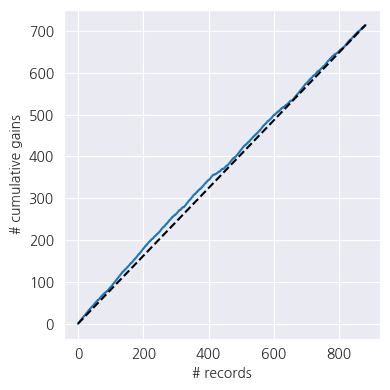

In [62]:
# convert y_valid to a categorical data type
y_valid = y_valid.astype('category')

df = pd.DataFrame({'actual':1-y_valid.cat.codes, 'prob':predProb_valid[:, 0]})
df = df.sort_values(by = ['prob'], ascending = False).reset_index(drop = True)

fig, ax = plt.subplots()
fig.set_size_inches(4,4)
gainsChart(df.actual, ax = ax)

plt.tight_layout()
plt.show()

In [65]:
np.exp(delays_nb.feature_log_prob_)

array([[0.49708304, 0.12572597, 0.00759929, 0.08144331, 0.03668576,
        0.03348031, 0.01959004, 0.072658  , 0.00439384, 0.02885022,
        0.02564477, 0.0147225 , 0.00130711, 0.02125212, 0.00213815,
        0.02742557],
       [0.48845264, 0.12787337, 0.01029317, 0.06663368, 0.05095632,
        0.04850673, 0.02548061, 0.05389582, 0.00735366, 0.04017813,
        0.01225284, 0.02842011, 0.00098473, 0.0279302 , 0.00196457,
        0.00882341]])

---------------------------------------

# 08. Tree & Logistic Regression

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
import dmba
from dmba import plotDecisionTree, classificationSummary, regressionSummary

## 분류 회귀 트리
* 가장 명료하며 결과에 대한 해석 용이
* 관측치들을 하위 그룹으로 분리해 나가는 절차의 반복
* 하위 그룹으로의 분할 작업-> 예측 변수 기반
* 재귀적 분할 (Recursive Partitioning) & 가지치기(pruning)
* 모델 생성 이후 대량의 표본을 처리하는 계산 용이함

In [4]:
mower_df = pd.read_csv('https://raw.githubusercontent.com/reisanar/datasets/master/RidingMowers.csv')

classTree = DecisionTreeClassifier(random_state = 0, max_depth = 1)
classTree.fit(mower_df.drop(columns = ['Ownership']), mower_df['Ownership'])

print("Classes: {}".format(','.join(classTree.classes_)))
plotDecisionTree(classTree, feature_names = mower_df.columns[:2], class_names = classTree.classes_)

Classes: Nonowner,Owner


'You need to install pydotplus to visualize decision trees'

In [8]:
! pip install pydotplus

  Using cached pydotplus-2.0.2.tar.gz (278 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [20 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\User\AppData\Local\Temp\pip-install-67ukf6u0\pydotplus_791cc04f5a7a4392a3c1f7178ff01c29\setup.py", line 55, in <module>
      setup(
    File "C:\Users\User\.conda\envs\condapractice\lib\site-packages\setuptools\__init__.py", line 87, in setup
      return distutils.core.setup(**attrs)
    File "C:\Users\User\.conda\envs\condapractice\lib\site-packages\setuptools\_distutils\core.py", line 147, in setup
      _setup_distribution = dist = klass(attrs)
    File "C:\Users\User\.conda\envs\condapractice\lib\site-packages\setuptools\dist.py", line 475, in __init__
      _Distribution.__init__(
    File "C:\Users\User\.conda\envs\condapractice\lib\site-packages\setuptools\_distutils\dist.py", line 283, in __i

In [9]:

classTree = DecisionTreeClassifier(random_state = 0)
classTree.fit(mower_df.drop(columns = ['Ownership']), mower_df['Ownership'])

print('Classes: {}'.format(',', feature_names = mower_df.columns[:2], class_names = classTree.classes_))
plotDecisionTree(classTree, feature_names = mower_df.columns[:2], class_names = classTree.classes_)

ModuleNotFoundError: No module named 'pydotplus'

## 트리 구조
### 기본 구조
* 결정 노드 (Decision Node) : 자식 노드를 가짐, 에측 변수 값만 알고 있는 새로운 관측치를 분류하기 위해 트리 모델을 사용할 경우 관측치를 트리에 떨어져서 적합한 값을 갖는 가지를 통해 트리 아래로 내려 보냄
* 단말 노드 (Terminal Node) : 자식이 없는 노드, 예측 변수에 의한 데이터의 분할

### 의사결정 규칙
* 트리가 적절하다면 모델이 제공하는 결정 기준이 이해하기 쉬움
* ex) 은행 고객들의 대출 신청 승인 모델
* 0은 대출 신청 거부, 1은 승인

* 분할 노드의 상단 조건 : 분할을 위해 예측값 & 분할값 제공(ex) 상위 노드의 소득 <= 110.5)
* Sample 해당 노드의 레코드 수
* Values 해당 노드에 있는 클래스 개수
* 분류 규칙 살펴보기
* ex) 트리 모델에서 결정 노드 'Family'의 아래 왼쪽 노드?
* --> IF 소득 > 110.5 & 교육 수준 < 1.5 & 가족 수 < 2.5 Then Class = 0 (거부)


### 새로운 관측치의 분류
* 관측치를 트리 모델의 위에서 아래로 할당하는 과정
* 새로운 관측치의 클래스는 투표를 통해 결정


### 재귀적 분할
* 종속 변수 : Y, 예측 변수 : X1, X2, ,,, Xn
* 분류 문제 -> 모델의 결과 변수가 범주형 변수
* 예측 변수들의 p차원 공간을 서로 겹치지 않는 다차원의 직사각형으로 분할
1. 하나의 변수 Xi 가 선택되고 p차원의 공간을 두 부분으로 분할하게끔 Xi의 변구 값인 Si가 선택
2. 이 중 한 부분은 Xi<=S인 모든 점 포함
3. 나누어진 두 부분 중 한 부분은 마찬가지로 동일한 과정에 의해 다시 한 번 변수를 선정
4. 위의 과정 반복

In [10]:
# 잔디깎이 기계 데이터를 로드 및 분할하고 산포도를 그리기 위한 코드

mower_df['Number'] = mower_df.index + 1
mower_df.head()

,Income,Lot_Size,Ownership,Number
0,60.0,18.4,Owner,1
1,85.5,16.8,Owner,2
2,64.8,21.6,Owner,3
3,61.5,20.8,Owner,4
4,87.0,23.6,Owner,5


In [12]:
trainData, validData = train_test_split(mower_df, test_size=0.4, random_state=26)
print(trainData, validData)
newHousehold = pd.DataFrame([{'Income':60, 'Lot_Size':20}])
newHousehold

    Income  Lot_Size Ownership  Number
5    110.1      19.2     Owner       6
3     61.5      20.8     Owner       4
7     82.8      22.4     Owner       8
20    47.4      16.4  Nonowner      21
18    59.4      16.0  Nonowner      19
2     64.8      21.6     Owner       3
4     87.0      23.6     Owner       5
0     60.0      18.4     Owner       1
13    52.8      20.8  Nonowner      14
22    51.0      14.0  Nonowner      23
1     85.5      16.8     Owner       2
16    84.0      17.6  Nonowner      17
6    108.0      17.6     Owner       7
21    33.0      18.8  Nonowner      22     Income  Lot_Size Ownership  Number
12    75.0      19.6  Nonowner      13
14    64.8      17.2  Nonowner      15
11    81.0      20.0     Owner      12
8     69.0      20.0     Owner       9
15    43.2      20.4  Nonowner      16
10    51.0      22.0     Owner      11
17    49.2      17.6  Nonowner      18
19    66.0      18.4  Nonowner      20
23    63.0      14.8  Nonowner      24
9     93.0      20.8     

,Income,Lot_Size
0,60,20


In [16]:
# 잔디깎이 기계 데이터를 로드 및 분할하고 산포도를 그리기 위한 코드

# ScatterPlot
fig, ax = plt.subplot()

subset = TrainData.loc[trainData['Ownership']=='Owner']
ax.scatter(subset.Income, subset.Lot_Size, marker = 'O', label = 'Owner', color = 'C1')

subset = TrainData.loc[trainData['Ownership']=='Nonwner']
ax.scatter(subset.Income, subset.Lot_Size, marker = 'D', label = 'Nonwner', color = 'C0')

ax.scatter(newHousehold.Income, newHousehold.Lot_Size, marker = '*', label = 'New Household', color = 'black', s = 150)

plt.xlabel('Income')
plt.ylabel('Lot_Size')
for _, fow in trainData.iterrows():
    ax.annotate(row.Number, (row.Income + 2, row.Lot_Size))

handles, labels = ax.get_legend_handles_labels()
ax.set_xlim(40, 115)
ax.legend(handles, labels, loc = 4)

plt.show()
! pip install --upgrade matplotlib


TypeError: cannot unpack non-iterable AxesSubplot object

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000001FD69746160> (for post_execute):
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\User\.conda\envs\condapractice\lib\site-packages\IPython\core\events.py", line 89, in trigger
    func(*args, **kwargs)
  File "C:\Users\User\.conda\envs\condapractice\lib\site-packages\matplotlib\pyplot.py", line 137, in post_execute
  File "C:\Users\User\.conda\envs\condapractice\lib\site-packages\matplotlib\_pylab_helpers.py", line 141, in draw_all
  File "C:\Users\User\.conda\envs\condapractice\lib\site-packages\matplotlib\backend_bases.py", line 2060, in draw_idle
  File "C:\Users\User\.conda\envs\condapractice\lib\site-packages\matplotlib\backends\backend_agg.py", line 400, in draw
    self.figure.draw(self.renderer)
  File "C:\Users\User\.conda\envs\condapractice\lib\site-packages\matplotlib\artist.py", line 74, in draw_wrapper
    if artist.get_agg_filter() is not None:
  File "C:\Users\User\.conda\envs\condapractice\lib\site-packages\matplotlib\artist.py", line 51, in draw_wrapper
    renderer.
  File "C:\Users\User\.conda\en

TypeError: print_png() got an unexpected keyword argument 'orientation'

<Figure size 640x480 with 1 Axes>

In [18]:
# Scatter Plot
fig, ax = plt.subplots()

subset = mower_df.loc[mower_df['Ownership']=='Owner']
ax.scatter(subset.Income, subset.Lot_Size, marker = 'o', label = 'Owner', color = 'C1')

subset = mower_df.loc[mower_df['Ownership']=='Nonwner']
ax.scatter(subset.Income, subset.Lot_Size, marker = 'D', label = 'Nonwner', color = 'C0')

plt.xlabel('Income')
plt.ylabel('Lot_Size')
for _,row in mower_df.iterrows():
    ax.annotate(row.Number, (row.Income + 2, row.Lot_Size))

handles, labels = ax.get_legend_handles_labels()
ax.set_xlim(20, 120)
ax.legend(handles, labels, loc = 4)

plt.show()

TypeError: print_png() got an unexpected keyword argument 'orientation'

<Figure size 640x480 with 1 Axes>

In [19]:
# 소득 60인 값을 기준으로 24개 관측치 분할
fig, ax = plt.subplots()

subset = mower_df.loc[mower_df['Ownership']=='Owner']
ax.scatter(subset.Income, subset.Lot_Size, marker = 'o', label = 'Owner', color = 'C1')

subset = mower_df.loc[mower_df['Ownership']=='Nonwner']
ax.scatter(subset.Income, subset.Lot_Size, marker = 'D', label = 'Nonwner', color = 'C0')

plt.xlabel('Income')
plt.ylabel('Lot_Size')
for _,row in mower_df.iterrows():
    ax.annotate(row.Number, (row.Income + 2, row.Lot_Size))

handles, labels = ax.get_legend_handles_labels()
ax.set_xlim(20, 120)
ax.legend(handles, labels, loc = 4)

ax.axvline(x = 60, color = 'black', linestyle = '--', label = 'Income = 60')

plt.show()

TypeError: print_png() got an unexpected keyword argument 'orientation'

<Figure size 640x480 with 1 Axes>

### 잔디깎이 기계 데이터를 로드 및 분할하고 산포도를 그리기 위한 코드
* 분할을 통해 생성된 2개의 직사각형은 분할 전 직사가형에 비해 동질적
* 좌측 : 대부분 비소유 & 우측 : 대부분 소유
* How?
1. 알고리즘은 최적의 분할을 찾기 위해, 변수와 각 변수에 대한 모든 분할 가능 값을 검토
2. 각 변수에 대한 분할 가능 값은 예측 변수가 갖는 연속된 두 값들 사이의 중간값
3. 소득 & 대지 크기
4. 분할 값은 분할의 결과로 생기는 직사각형에서 얼마나 많이 분순도(이질성)를 감소시켰는가를 통해 순위 겨정
* 순수한 직사각형 ? -> 하나의 클래스에 속한 점들로만 구성
* 불순도 감소 -> 분할 전의 전체 불순도에서 분할 수의 3개 직사각형에 대한 불순도의 합을 뺸 값

## 불순도 측정
* 지니 지수( Gini index) & 엔트로피 측도(Entropy measure)
* 지니 지수 : 두 측정치에 대한 반응 변수가 m 개의 클래스를 갖고 k = 1, 2, 3, ...로 표기
* 측정치는 0~(m-1)/m (관측치들이 m개의 클래스에 동일하게 분포)

### 잔디깎이 기계 데이터를 로드 및 분할하고 산포도를 그리기 위한 코드
* 소득 60인 값을 기준으로 24개 관측치 분할
* 대지의 크기 21.4인 값을 기준으로 분할
* 위의 과정 반복

In [20]:
# 분류 트리 실행, 시각화 코드
classTree = DecisionTreeClassifier(random_state = 0, max_depth = 1)
classTree.fit(mower_df.drop(columns = ['Ownership']), mower_df['Ownership'])

print("Classes: {}".format(','.join(classTree.classes_)))
plotDecisionTree(classTree, feature_names = mower_df.columns[:2], class_names = classTree.classes_)

Classes: Nonowner,Owner


'You need to install pydotplus to visualize decision trees'

In [21]:
# 분류 트리 실행, 시각화 코드
classTree = DecisionTreeClassifier(random_state = 0, max_depth = 2)
classTree.fit(mower_df.drop(columns = ['Ownership']), mower_df['Ownership'])

print("Classes: {}".format(','.join(classTree.classes_)))
plotDecisionTree(classTree, feature_names = mower_df.columns[:2], class_names = classTree.classes_)

Classes: Nonowner,Owner


'You need to install pydotplus to visualize decision trees'

In [23]:
# 분류 트리 실행, 시각화 코드
classTree = DecisionTreeClassifier(random_state = 0)
classTree.fit(mower_df.drop(columns = ['Ownership']), mower_df['Ownership'])

print("Classes: {}".format(','.join(classTree.classes_)))
plotDecisionTree(classTree, feature_names = mower_df.columns[:2], class_names = classTree.classes_)

Classes: Nonowner,Owner


'You need to install pydotplus to visualize decision trees'

### 성능 평가
* 모델을 평가하고 조정하려면 학습 데이터 셋 외에 표본 데이터가 필요함
* 트리 구조는 선택된 표본에 따라서 불안정
* 완전 적합된 트리 모델은 과적합(over-fitting)이슈 존재

## 예제 : 개인 대출 수락
### 분류 트리를 활용한 개인 대출 수락 여부 예측
* UniversalBank 고객 데이터 (5000명)를 학습 (60%)&검증(40%)로 나눠 트리 모형 설계
* 검증은 어떻게? -> CV를 통해 서로 다른 데이터 분할에 대한 성능 변동 파악


### 과적합 방지
* 다양한 분할 레벨에서 모델의 총 오류를 살펴보면, 과적합이 일어나는 점에 이르기까지 분할 레벨의 수는 증가 -> 총 오류는 감소
* 학습 데이터의 총 오류는 최대 분할 레벨에서 0이 될 떄까지 줄어듦
* 분할 레벨에 따른 과적합의 이유 ? -> 적은 수의 관측치로 분할

### 트리 모델 성장 중단
* 과적합 되기 전 성장 중단
* 범용적 기준 : 트리 모데의 깊이, 노드의 최소 관측치 수, 불순도의 최소 감소량 등

### Grid Search
* 과적합 되기 전 성장 중단
* 어떻게 성장을 멈출 것인가? 가장 좋은 타이밍은? -> Grid Search
* 파라미터 최적 조합 : 최대 깊이 [1,30], 단말 노드의 최소 레코드 수 [20,100], 불순도 기준[0.001, 0.01]
* Grid Search는 각각의 데이터 셋(학습, 검증)에 대해 과적합 이슈가 발생할 가능성
* 학습 데이터셋에서 CV 수행 -> Best model 선정 -> 해당 모델에 대해 새로운 검증 데이터 셋으로 평가

## 회귀 트리 모델
### 트리 모델을 활용하여 연속형 반응 변수 예측
* 분류 문제와 본질적으로 같음
* 분할이 시도되고 결과로 나온 트리 모델들의 모든 가지에 대해 불순도 측정
* -> 다음 단계에서 불순도의 합이 최소가 되는 분할 선택

In [25]:
toyota_df = pd.read_csv('https://raw.githubusercontent.com/reisanar/datasets/master/ToyotaCorolla.csv').iloc[:1000]
toyota_df = toyota_df.rename(columns = {'age_08_04':'age', 'quarterly_tax':'tax'})

predictors = ['age', 'km', 'fuel_type','hp','met_color', 'automatic','cc','doors','tax','weight']
outcome = 'price'

X = pd.get_dummies(toyota_df[predictors], drop_first=True)
y = toyota_df[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.4, random_state = 1)

# user grid search to find optimized tree
param_grid = {'max_depth' :[5,10,15,20,25], 'min_impurity_decrease' : [0,0.001,0.005,0.01], 'min_samples_split' : [10,20,30,40,50]}
gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = 5, n_jobs = -1)
gridSearch.fit(train_X, train_y)
print('Initial parameters: ', gridSearch.best_params_)

param_grid = {
    'max_depth' :[3,4,5,6,7,8,9,10,11,12],
    'min_impurity_decrease' : [0,0.001,0.002,0.003,0.005,0.006,0.007,0.008],
    'min_samples_split' : [14, 15, 16, 18, 20]
}
gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = 5, n_jobs = -1)
gridSearch.fit(train_X, train_y)
print('Improved parameters: ', gridSearch.best_params_)

regtree = gridSearch.best_estimator_

Initial parameters:  {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_split': 20}
Improved parameters:  {'max_depth': 6, 'min_impurity_decrease': 0, 'min_samples_split': 16}


In [27]:
regressionSummary(train_y, regtree.predict(train_X))
regressionSummary(valid_y, regtree.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1058.8202
            Mean Absolute Error (MAE) : 767.7203
          Mean Percentage Error (MPE) : -0.8074
Mean Absolute Percentage Error (MAPE) : 6.8325

Regression statistics

                      Mean Error (ME) : 60.5241
       Root Mean Squared Error (RMSE) : 1554.9146
            Mean Absolute Error (MAE) : 1026.3487
          Mean Percentage Error (MPE) : -1.3082
Mean Absolute Percentage Error (MAPE) : 9.2311


In [29]:
plotDecisionTree(regtree, feature_names = train_X.columns)
plotDecisionTree(regtree, feature_names = train_X.columns, rotate = True)

'You need to install pydotplus to visualize decision trees'

## 트리 모델 발전
### 앙상블(Ensemble)
* 여러 머신러닝 모델을 조합하여 강력한 모델 디자인
* 의사 결정 트리 -> 랜덤 포레스트 (Random Forest) -> 그래디언트 부스팅 (Gradient Boosting)

### 랜덤 포레스트
* 훈련 데이터에 과적합 되는 의사 결정 트리
* Bagging의 특별한 경우, 다중 분류/예측 알고리즘을 조합하여 예측 성능 향상

### Procedure
* 복원 추출 방식으로 데이터로부터 여러 랜덤 표본을 생성 (Bootstrap)
* 각 단계마다 랜덤으로 예측 변수들을 선택하여 서브셋 생성 -> 표본에  대해 분류 트리 적합
* 예측을 향상시키기 위해서 각 트리로부터 얻은 예측/분류 결과를 결합
* 분류 -> 투표(voting) & 예측 -> 평균화 (Averaging)

In [30]:
## p.27
bank_df = pd.read_csv('https://raw.githubusercontent.com/gchoi/Dataset/master/UniversalBank.csv')
bank_df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [32]:
bank_df = bank_df.drop(columns = ['ID', 'ZIP Code'])
bank_df.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1


In [38]:
len(bank_df[bank_df['PersonalLoan']==1])

480

In [39]:
X = bank_df.drop(columns = ['PersonalLoan'])
y = bank_df['PersonalLoan']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.4, random_state = 1)

fullClassTree = DecisionTreeClassifier()
fullClassTree.fit(train_X, train_y)

plotDecisionTree(fullClassTree, feature_names = train_X.columns)

'You need to install pydotplus to visualize decision trees'

In [40]:
classificationSummary(train_y, fullClassTree.predict(train_X))
classificationSummary(valid_y, fullClassTree.predict(valid_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0 2713    0
     1    0  287
Confusion Matrix (Accuracy 0.9790)

       Prediction
Actual    0    1
     0 1790   17
     1   25  168


In [45]:
# full- 결정 트리의 5 - fold 교차 검증
treeClassifier = DecisionTreeClassifier()

scores = cross_val_score(treeClassifier, train_X, train_y, cv = 5)
print('Accuracy scores of each fold: ', [f'{acc:.3f}' for acc in scores])
print(f'Accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})')
print(f'Accuracy: {scores.mean():.3f} (+/- {scores.std():.3f})')

Accuracy scores of each fold:  ['0.983', '0.977', '0.992', '0.985', '0.993']
Accuracy: 0.986 (+/- 0.012)
Accuracy: 0.986 (+/- 0.006)


In [46]:
# Plot accuracy asores of each fold
fig, ax = plt.subplots()
ax.plot(range(1,6), scores, 'o-')
ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of DT according to 5-fold cross-validation')
ax.set_xticks(range(1,6))
ax.set_ylim(0.9,1)
plt.show()

TypeError: print_png() got an unexpected keyword argument 'orientation'

<Figure size 640x480 with 1 Axes>

In [50]:
! pip install --upgrade matplotlib


### 과적합 방지
* 다양한 분할 레벨에서 모델의 총 분류를 살펴보면, 과적합이 일어나는 점에 이르기까지 분할 레벨의 수는 증가 -> 총 오류는 감소
* 학습 데잍의 총 오류는 최대 분할 레벨에서 0이 될 때까지 줄어듧
* 분할 레벨에 따른 과적합의 이유 ? -> 적은 수의 관측치로 분할

In [51]:
smallClassTree = DecisionTreeClassifier(max_depth = 30, min_samples_split = 20, min_impurity_decrease = 0.01)
smallClassTree.fit(train_X, train_y)

plotDecisionTree(smallClassTree, feature_names = train_X.columns)

'You need to install pydotplus to visualize decision trees'

In [54]:
# p.43
ubank_df = pd.read_csv("https://raw.githubusercontent.com/gchoi/Dataset/master/UniversalBank.csv")
ubank_df = ubank_df.drop(columns = ['ID', 'ZIP Code'])

X = ubank_df.drop(columns = ['PersonalLoan'])
y = ubank_df['PersonalLoan']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.4, random_state = 1)

rf = RandomForestClassifier(n_estimators= 500,random_state = 1 )
rf.fit(train_X, train_y)

RandomForestClassifier(n_estimators=500, random_state=1)

In [58]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis = 0)

df = pd.DataFrame({'feature': train_X.columns, 'importance' : importances, 'std' : std})
df = df.sort_values('importance')
print(df)

ax = df.plot(kind = 'barh', xerr = 'std', x = 'feature', legend = False)
ax.set_ylabel("")

plt.tight_layout()
plt.show()

              feature  importance       std
7   SecuritiesAccount    0.003964  0.004998
9              Online    0.006394  0.005350
10         CreditCard    0.007678  0.007053
6            Mortgage    0.034243  0.023469
1          Experience    0.035539  0.016061
0                 Age    0.036258  0.015858
8           CDAccount    0.057917  0.043185
3              Family    0.111375  0.053146
4               CCAvg    0.172105  0.103011
5           Education    0.200772  0.101002
2              Income    0.333756  0.129227
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\User\.conda\envs\condapractice\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
    nnode = ast.Expr(ast.Name(target.id, ast.Load()))
  File "C:\Users\User\AppData\Local\Temp\ipykernel_21956\636905909.py", line 11, in <cell line: 11>
    plt.tight_layout()
  File "C:\Users\User\.conda\envs\condapractice\lib\site-packages\matplotlib\pyplot.py", line 2312, in tight_layout
    # Autogenerated by boilerplate.py.  Do not edit as changes will be lost.
  File "C:\Users\User\.conda\envs\condapractice\lib\site-packages\matplotlib\figure.py", line 3236, in tight_layout
    fname : str or path-like or binary file-like
  File "C:\Users\User\.conda\envs\condapractice\lib\site-packages\matplotlib\tight_layout.py", line 320, in get_tight_layout_figure
  File "C:\Users\User\.conda\envs\condapractice\lib\site-packages\matplotlib\tight_layout.py", line 82, in _auto_adjust_subplotpars
  File "C:\Users\User\.conda\envs\condapra

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000001FD69746160> (for post_execute):
Unexpected exception formatting exception. Falling back to standard exception


TypeError: print_png() got an unexpected keyword argument 'orientation'

<Figure size 640x480 with 1 Axes>

In [60]:
classificationSummary(valid_y, rf.predict(valid_X))

Confusion Matrix (Accuracy 0.9820)

       Prediction
Actual    0    1
     0 1803    4
     1   32  161
